# Problem Set 5, due March 8 at 11:59am, mid-day, noon.

As usual, you are highly encouraged to *start this problem set early!*  My best guess (no guarantees!) is that Part 1 will be conceptually easy but perhaps time consuming.  Parts 2 and 3 are medium difficult, but there are plenty of opportunities to get confused with python data structures, so if you're going to get stuck, get stuck (and unstuck) early! Part 4 will give you an opportunity to get some intuition with PCA.

Note that the two extra credit problems have the potential to be quite challenging and time consuming. Make sure to do everything else in the problem set before you tackle the extra credit.

To get started, download the files "reviews.csv" and "movies.dat" from Canvas.

For this assignment, the following libraries may be useful:

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting

In particular, I suggest you familiarize yourself with the following aspects of these libraries, which are not required but which might make your life easier:

* `DataFrame` and other basic [data structures](http://pandas.pydata.org/pandas-docs/stable/dsintro.html) in pandas
* [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html), `unique`,  and other simple aggregation functions
* [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) for working with text in sklearn.
* [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for Naive Bayes
* Simple tools for [Cross-Validation](http://scikit-learn.org/stable/modules/cross_validation.html) in sklearn

Make sure they load properly with the following code block:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn import cross_validation
from  sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

## Introduction to the assignment

In this assignment, you'll be analyzing movie reviews in an attempt to determine whether movies are good or bad.  I've downloaded a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) website, which are available in the file "reviews.csv" on Canvas.  I've also put a file "movies.dat" on Canvas that contains metadata for ~65,000 different movies

If you've never seen Rotten Tomatoes before, go spend a few minutes familiarizing yourself with the website.  It's a meta-review website that aggregates movie reviews from a large number of critics.  Here's what the page for this year's likely [Oscar winner](http://www.rottentomatoes.com/m/the_revenant_2015/) looks like.  Note in particular the section on "Critic Reviews" at the bottom -- that's the content that has been scraped and put in the reviews.csv file.  Also note that each movie is given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

Your mission is to develop a classifier to determine whether a movie is Fresh or Rotten based on the contents of the reviews given to the movie.  As usual, we'll start out with some exploratory data analysis.

---

## Part 1: Descriptive analysis

Before beginning the "real" work, dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data:

In [2]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')

reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

### 1.1: Basic features of the dataset

Answer the following questions by having your python code directly print the answers:

* How many unique reviews (quotes) are in the `reviews` dataset?
* How many unique reviewers (critics) are in the `reviews` dataset?
* How many unique movies are in the `reviews` dataset?
* How many unique movies are in the *`movies`* dataset?
* How many different publications have reviews in the `reviews` dataset?


In [3]:
# enter your code below

print 'Number of reviews: %i' % len(reviews)
print 'Number of unique reviewers: %i' % len(reviews.critic.unique())
print 'Number of unique movies in "reviews": %i' % len(reviews.title.unique())
print 'Number of unique movies in "movies": %i' % len(movies.title.unique())
print 'Number of different publications in "reviews": %i' % len(reviews.publication.unique())


Number of reviews: 13419
Number of unique reviewers: 541
Number of unique movies in "reviews": 1720
Number of unique movies in "movies": 9405
Number of different publications in "reviews": 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, create a histogram showing the distribution of the number of reviews per reviewer.  Create the bin width (x-axis) to be 1 unit wide, and the range of the axis to be from 0 to 30.  Scale the y-axis to show the logarithm of (count of) the number of reviews.  Label your axes and make your histogram look professional.

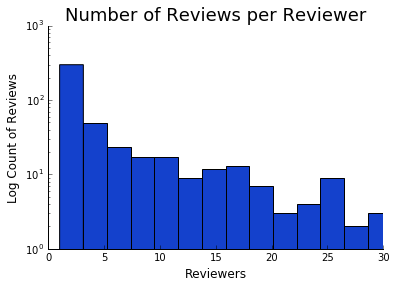

In [4]:
# plot the histogram  
x = reviews.critic.value_counts()

plt.hist(reviews.critic.value_counts(),541, color='#1441CC')
plt.gca().set_yscale('log')
plt.gca().set_xlim([0,30])

# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off

# apply labels
plt.gca().set_xlabel('Reviewers', fontsize = 12)
plt.gca().set_ylabel('Log Count of Reviews', fontsize = 12)
plt.gca().set_title('Number of Reviews per Reviewer', fontsize = 18)

### 1.3 Zoom in on a few reviewers
Find the 30 critics with the most reviews, and list their names in a table along with (a) the name of the publication they work for, (b) the date of their first review, and (c) the date of their last review

*hint: use the groupby function to do this quickly*

In [5]:
# group the data by critic
grouped_critic = reviews.groupby(['critic'], as_index=True)

# aggregate by publication
pub = pd.DataFrame(grouped_critic['publication'].agg(max))

# aggregate by review date
review_dates = pd.DataFrame(grouped_critic['review_date'].agg([min, max]))

# select the top 30 critics
top30 = pd.DataFrame(grouped_critic.size().sort_values(ascending=False).head(30)).reset_index()

# merge the df's together
top30 = pd.merge(top30, pub, left_on=['critic'], right_index=True, how='left')
result = pd.merge(top30, review_dates, left_on=['critic'], right_index=True, how='left')

# trim and rename the columns
result = result[['critic', 'publication', 'min', 'max']]
result.columns = ['critic', 'publication', 'first review', 'last review']

result



,critic,publication,first review,last review
0,Roger Ebert,Chicago Sun-Times,2000-01-01 00:00:00,2013-06-11 00:00:00
1,James Berardinelli,ReelViews,1800-01-01 00:00:00,2012-02-07 00:00:00
2,Janet Maslin,New York Times,2000-01-01 00:00:00,2010-09-07 00:00:00
3,Variety Staff,Variety,2001-02-13 00:00:00,2012-08-15 00:00:00
4,Jonathan Rosenbaum,Chicago Reader,1988-07-11 00:00:00,2013-10-22 00:00:00
5,Desson Thomson,Washington Post,2000-01-01 00:00:00,2012-10-08 00:00:00
6,Geoff Andrew,Time Out,2005-08-11 00:00:00,2012-04-05 00:00:00
7,Dave Kehr,New York Daily News,2000-01-01 00:00:00,2013-11-20 00:00:00
8,Kenneth Turan,Los Angeles Times,2000-01-01 00:00:00,2013-10-05 00:00:00
9,Mick LaSalle,San Francisco Chronicle,2000-01-01 00:00:00,2009-11-25 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, create a plot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time.  Do this by creating a scatterplot where the x-axis is the year in which the movie was released and the y-axis is rtAllCriticsRating.  Drop movies with 0 or unknown values to avoid biasing your results.  Then, create a scatterplot that has one <year,rating> point for each remaining movie, and pick an appropriate size/color/transparency for these points to ensure that the graph looks professional.  In other words, do not simply use the default settings, as this will produce a dense mess of dots that will be hard to interpret.  Finally, overlay on this scatterplot a line graph in orange showing how the average movie rating (the average of rtAllCriticsRating across all movies in a year) has changed over time.  Do you notice a trend?  What do you think it means?

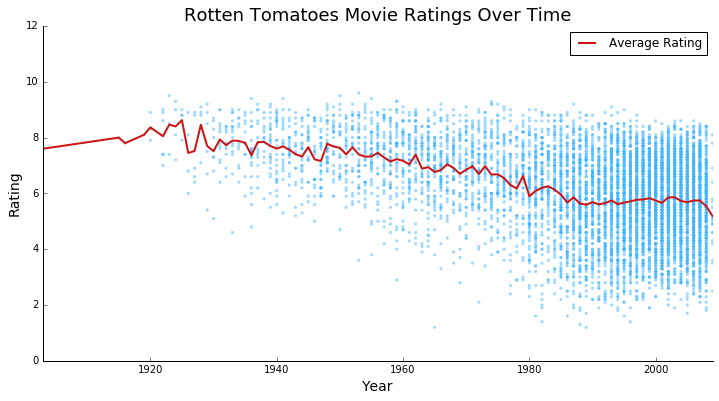

In [6]:
# load Data, drop rows w/ zero/unknown ratings
movies = pd.read_csv("movies.dat", delimiter='\t')
movies = movies[~movies.rtAllCriticsRating.isnull()]
movies = movies[movies.rtAllCriticsRating != '\N']
movies = movies[movies.rtAllCriticsRating != '0']

# set datatypes
movies['year'] = movies.year.astype(int)
movies['rtAllCriticsRating'] = movies.rtAllCriticsRating.astype(float)

# create scatter plot of rating by year
ax = movies.plot(kind='scatter',x='year', y='rtAllCriticsRating', alpha = .5, s=10,figsize=(12, 6), c='#3FB6FF', edgecolors='none')

# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off

# create mean line data:
# group movies by year, aggregate by mean rating
grouped_movies = movies.groupby(['year'], as_index=False)
movies_by_year = pd.DataFrame(grouped_movies['rtAllCriticsRating'].agg('mean'))

# plot mean line
movies_by_year.plot(kind='line', x='year', y='rtAllCriticsRating', c = '#CC1414', ax=ax\
                    , label='Average Rating', linewidth=2)

# apply labels
plt.gca().set_xlabel('Year', fontsize=14)
plt.gca().set_ylabel('Rating', fontsize=14)
plt.gca().set_title('Rotten Tomatoes Movie Ratings Over Time', fontsize=18)

Ratings appear to show a downward trend over time: older movies have on average higher ratings. This is not to say that older movies are better (though some would certainly argue so). There could be other factors at play, like selection bias. For example, perhaps not all older movies are included in the database. Instead, perhaps only classics or movies of a certain level of notoriety. Even more important may be human factors like nostalgia which may influence raters' opinions. It is also possible that newer movies are indeed worse on average. I submit as evidence The Hangover and The Hangover II.

---

## Part 2: Naive Bayes

Now it gets fun!  You are going to use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. Review the assigned readings on Canvas, as well as the relevant lecture notes before embarking on this journey.

### Using CountVectorizer

One thing that may help you in the following problems is the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn.  This will help you convert your raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb.  Here's a simple example, make sure you understand what's going on!

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['machine learning rocks', 'machine learning rules', 'rocks rocks rules']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

Original text is
machine learning rocks
machine learning rules
rocks rocks rules

Transformed text vector is 
[[1 1 1 0]
 [1 1 0 1]
 [0 0 2 1]]

Words for each feature:
[u'learning', u'machine', u'rocks', u'rules']


### 2.1 Create your X input and Y output

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.
 
Make sure to remove items with no review text

In [8]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    
    if vectorizer == None:
        vectorizer = CountVectorizer()

    # call `fit_transform` to fit and convert text to a bag of words
    X = vectorizer.fit_transform(reviews.quote)

    # CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
    # convert back to a "normal" numpy array
    
    # Commented out the below command because it is waaay faster to leave as sparse array (uncomment for debugging)
    #X = X.toarray() 
    
    Y = np.array((reviews.fresh == 'fresh').astype(int))

    return X,Y

X, Y = make_xy(reviews)

In [9]:
X, Y

(<13419x20875 sparse matrix of type '<type 'numpy.int64'>'
 	with 242600 stored elements in Compressed Sparse Row format>,
 array([1, 1, 1, ..., 1, 0, 0]))

### 2.2 Test-Train split

Next, randomly split the data into two groups: a training set and a validation set.  You can do this manually, as you did in the prior problem set.  Or, use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to do this auto-magically.  See [this guide](http://scikit-learn.org/stable/modules/cross_validation.html) for a simple example of how `train_test_split` works.

In [11]:
# create train, test sets for X,Y
xtrain, xtest, ytrain, ytest = \
cross_validation.train_test_split(X, Y, test_size=0.4, random_state=11)

# verify shapes
print xtrain.shape, ytrain.shape
print xtest.shape, ytest.shape


(8051, 20875) (8051,)
(5368, 20875) (5368,)


### 2.3 Naive Bayes with `MultinomialNB`
Use the training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
 object.  Report the accuracy of this model on both the training and testing data.  What do you observe?  Interpret these results!

*Hint: This shouldn't take more than 5-10 lines of code to accomplish*



In [12]:
# fit naive bayes model on training set
fitted_model = MultinomialNB()
fitted_model.fit(xtrain, ytrain)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
# predict target values for model using training set
ytrain_hat = fitted_model.predict(xtrain)
# compute accuracy on training data
print 'Training accuracy: %.4f' % (np.mean(ytrain_hat == ytrain))

ytest_hat = fitted_model.predict(xtest)
print 'Test accuracy: %.4f' % (np.mean(ytest_hat == ytest))



Training accuracy: 0.9286
Test accuracy: 0.7697


Naive Bayes performs well on training data predictions (92% accuracy), and not as well on test data predictions (77% accuracy). This indicates overfitting of the data. Even considering the overfitting problem, 77% accuracy is better than I would have expected given the assumption of independence between the words.  

### 2.4 (EXTRA CREDIT) Naive Bayes from Scratch!
That was almost too easy, right?  Right.

Your next mission, should you choose to accept it, is to write your own Naive Bayes classifier without relying on `MultinomialNB` or a similar pre-written package.  In addition to the lecture notes and assigned readings, I highly recommend that you review Michael Collin’s lecture notes on Naïve Bayes before starting (available on Canvas).  

**Note:**
You should do this extra credit assignment *after* you have finished the rest of the problem set.  It is very rewarding, but can also be quite time-consuming!

*Hint: You will benefit most from this exercise if you attempt to write the algorithm directly from the lecture notes.  That said, if you really get stuck, Krishnamurthy Viswanathan has written a simple version of [NB in python](http://ebiquity.umbc.edu/blogger/2010/12/07/naive-bayes-classifier-in-50-lines/), which you can peek at if you really get stuck.*

In [118]:
import math
'''
Function
--------
my_bayes

Naive Bayes function. Takes in arrays (x ndarray and y 1d array) and returns class from y and probability for each x
example

Parameters
-----------
x : n-dimensional numpy array 
    Data to be classified as y class

    
y : 1-dimensional numpy array with length equal to x
    Class labels corresponding to x records
    
Returns
-------
Yhat_probs : numpy array (dims: nclass)
    n-dimensional float array of probabilites that example is member of class

Examples
--------

my_bayes(xtrain, ytrain, xtest)

'''

def my_bayes(xtrain, ytrain, xtest):
    # set x inputs to np.arrays
    xtest = xtest.toarray()
    xtrain = xtrain.toarray()
    # calculate classes, number in each
    y_class, class_counts = np.unique(ytrain, return_counts=True)
    
    # calculate prior class probabilities (p(C))    
    priors = class_counts.astype(float) / len(ytrain)
    
    # create list to hold conditional probabilities (p(w|C))
    conditionals = []
    for cl in y_class:
        # split training data by class
        x_by_class = xtrain[np.where(ytrain==cl)]
        # calculate maximum likelihood estimates for each feature in training set
        x_mle = x_by_class.sum(axis=0).astype(float)/len(x_by_class.sum(axis=0))
        # save array of MLEs to conditionals
        conditionals.append(x_mle)
    # convert to np.array
    conditionals = np.array(conditionals)
    
    # multiply conditional mles by test set word counts
    cond_probs = np.dot(conditionals, xtest.T)
    
    # add log probs of prior  and conditional 
    yhat = np.add(np.log(priors), np.log(cond_probs).T).T
    # convert back to probabilities from log probabilities
    yhat = math.e**yhat
    # set yhats probabilities to total 1
    yhat = yhat / np.sum(yhat, axis = 0)
        
    return yhat

print my_bayes(xtrain,ytrain,xtest)

[[ 0.24374975  0.23845621  0.24607264 ...,  0.25338099  0.25370956
   0.28134739]
 [ 0.75625025  0.76154379  0.75392736 ...,  0.74661901  0.74629044
   0.71865261]]


In [119]:
# test my_bayes using test/training sets
yhat = my_bayes(xtrain,ytrain,xtest)

print 'Test accuracy: %.4f' % (np.mean(np.argmax(yhat, axis=0) == ytest))


Test accuracy: 0.6231


I am fairly certain there is something wrong with the above code, but it is close to naive bayes. The test accuracy seems to reflect the prior probability more than anything, and is not affected much by the conditional probabilities. I'm looking forward to seeing the solution for this one.

---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, you can compute the log-likelihood of your data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given your fitted model from part 2.

To help you out a little bit, we'll do this part for you. But make sure you understand it, because you'll need to use this later!

In [14]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, xtest, ytest)

-3162.0346679804525

### 3.2 Cross-Validation

Why do we care about the log-likelihood of our data?  You guessed it: Cross-Validation.

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

How are we are going to use cross-validation to tune these hyperparameters?  The objective function we want to maximize is the log-likelihood of our data.  Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood.

*hint: sklearn has a built-in function, `sklearn.cross_validation.cross_val_score`, that might save you a lot of time here...*

In [15]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf


for alpha in alphas:
    for min_df in min_dfs:         
        # choose vectorizer with min_df
        vectorizer = CountVectorizer(min_df = min_df)       
        
        # build bag-of-words matrix (X) and 1/0 array (Y)
        X, Y = make_xy(reviews, vectorizer)
        
        # define naive bayes model with alpha
        fitted_model = MultinomialNB(alpha=alpha)
        
        # estimate log likelihood on test data
        score = cross_validation.cross_val_score(fitted_model, X, Y, scoring = log_likelihood).mean()
        
        print alpha, min_df, score
        
        # update 'best' values
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df


print 'Best alpha: %s, Best min_def: %.5f, Max loglike: %.9f' % (best_alpha, best_min_df, max_loglike)
     

0 1e-05 nan
0 0.0001 nan
0 0.001 nan
0 0.01 -2807.60550331
0 0.1 -2908.06027747
0.1 1e-05 -3922.81445287
0.1 0.0001 -3920.80980545
0.1 0.001 -2788.26008898
0.1 0.01 -2807.31820944
0.1 0.1 -2908.05876678
1 1e-05 -2684.16233569
1 0.0001 -2633.08384867
1 0.001 -2612.04885544
1 0.01 -2804.87652365
1 0.1 -2908.04543903
5 1e-05 -4569.6089708
5 0.0001 -3274.02664404
5 0.001 -2482.89345479
5 0.01 -2796.60258611
5 0.1 -2907.99194518
10 1e-05 -6208.43842155
10 0.0001 -4676.48956883
10 0.001 -2534.25708801
10 0.01 -2790.52234972
10 0.1 -2907.93779446
50 1e-05 -7732.17656358
50 0.0001 -7064.92626789
50 0.001 -4141.08834896
50 0.01 -2818.62772991
50 0.1 -2907.93436322
Best alpha: 5, Best min_def: 0.00100, Max loglike: -2482.893454791


### 3.3 Putting it together

Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy.  Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse?

In [22]:
# create and fit vectorizer
vectorizer = CountVectorizer(min_df = best_min_df)       
X, Y = make_xy(reviews, vectorizer)

# split X,Y into training and test sets
xtrain, xtest, ytrain, ytest = \
cross_validation.train_test_split(X, Y, test_size=0.4, random_state=97531)

# fit NB model using training data
fitted_model = MultinomialNB(alpha= 10, class_prior=None, fit_prior=True)
fitted_model.fit(xtrain, ytrain)

# predict target values for model using training set
ytrain_hat = fitted_model.predict(xtrain)
# compute accuracy on training data
print 'Training accuracy: %.4f' % (np.mean(ytrain_hat == ytrain))

ytest_hat = fitted_model.predict(xtest)
print 'Test accuracy: %.4f' % (np.mean(ytest_hat == ytest))

Training accuracy: 0.6512
Test accuracy: 0.6360


"Tuning" the parameters results in poorer performance, but with less overfitting. Less overfitting is expected with increasing alpha, as it tends to pull probabilities to the mean. But I am surprised that the test accurcy is worse as a result. The higher min_df value decreases the overall number of features. Perhaps this leads to worse overall performance in a sparse feature set.

### 3.4 (Extra Credit)

What happens if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?  Interpret these results

In [17]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf


def predict_accuracy(model, x,y):
    y_hat = model.predict(x)
    return np.mean(y_hat == y)

for alpha in alphas:
    for min_df in min_dfs:         
        # choose vectorizer with min_df
        vectorizer = CountVectorizer(min_df = min_df)       
        # build bag-of-words matrix (X) and 1/0 array (Y)
        X, Y = make_xy(reviews, vectorizer)
        # define naive bayes model with alpha
        fitted_model = MultinomialNB(alpha=alpha)
        '''
        # split X,Y into training and test sets
        xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, Y, test_size=0.4, random_state=13579)  
        # fit the model on the training data
        fitted_model.fit(xtrain, ytrain)
        # estimate log likelihood on test data
        '''
        score = cross_validation.cross_val_score(fitted_model, X, Y, scoring = predict_accuracy).mean()
        
        print alpha, min_df, score
        
        # update 'best' values
        if score > max_loglike:
            max_loglike = score
            best_alpha = alpha
            best_min_df = min_df


print 'Best alpha: %s, Best min_def: %.5f, Max test accuracy: %.9f' % (best_alpha, best_min_df, max_loglike)
     

0 1e-05 0.549520056262
0 0.0001 0.600492359856
0 0.001 0.73418208327
0 0.01 0.661523726222
0 0.1 0.625978161654
0.1 1e-05 0.738653738514
0.1 0.0001 0.738802397742
0.1 0.001 0.73649244053
0.1 0.01 0.661523726222
0.1 0.1 0.625978161654
1 1e-05 0.761681107055
1 0.0001 0.760861290514
1 0.001 0.7379826647
1 0.01 0.661300145946
1 0.1 0.625903657109
5 1e-05 0.669424373278
5 0.0001 0.710113633681
5 0.001 0.730753841314
5 0.01 0.660778647446
5 0.1 0.625903690429
10 1e-05 0.63939237814
10 0.0001 0.654669191589
10 0.001 0.722109831408
10 0.01 0.659064793024
10 0.1 0.625978244951
50 1e-05 0.625605472283
50 0.0001 0.625605472283
50 0.001 0.635144419633
50 0.01 0.65653128867
50 0.1 0.626350834301
Best alpha: 1, Best min_def: 0.00001, Max test accuracy: 0.761681107


The best cross-validated parameters are nearly the same as the original parameters, with alpha = 1 and min_df = .00001. Of course, the original test was with min_df  = 0 and the test accuracy was a percentage point better. This seems to tell us that with this dataset, raising the min_df threshold decreases performance. This is probably due to the fact that higher min_df will give a smaller overall feature set to work with, and with such a sparse feature space it decreases the likelihood that a review in the test set will have many of the same features that the model trained on.

### 3.5 Interpretation

What words best predict a fresh or rotten review?  Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints
* In thinking about how to measure the impact of a word on freshness rating, consider computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?
* `numpy.identity` generates an identity matrix, where all values are zero except the diagonal elements which have a value of one

In [18]:
# use parameters from section 3.4 for best prediction accuracy
vectorizer = CountVectorizer(min_df = .0001)       

# build bag-of-words matrix (X) and 1/0 array (Y)
X, Y = make_xy(reviews, vectorizer)

# define naive bayes model with alpha
fitted_model = MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
fitted_model.fit(X, Y)

# get probabilities for each term
probs = fitted_model.predict_proba(np.identity(X.shape[1]))

# split into rotten and fresh vectors of probabilities
rotten_probs = probs[:,0]
fresh_probs = probs[:,1]



In [125]:
# get the indices of the 10 words associated with rotten that have the highest probabilities
rotten_feat_idx = np.argpartition(rotten_probs, -10, axis = 0)[-10:]

# get the feature names (terms) 
rotten_names = np.array(vectorizer.get_feature_names())

# filter only the terms from the top 10
rotten_names = rotten_names[rotten_feat_idx]
rotten_probs = np.array(rotten_probs[rotten_feat_idx])

# create dataframe with top ten rotten words and probability from above arrays
rotten10_df = pd.DataFrame({'Top Rotten Words': rotten_names, 'Rotten Probability': rotten_probs})
rotten10_df.sort_values(['Rotten Probability'], ascending = 0, inplace = True)
rotten10_df.reset_index(inplace = True, drop = True)

print rotten10_df

   Rotten Probability Top Rotten Words
0            0.963114             lame
1            0.961749        pointless
2            0.955107       uninspired
3            0.955107    unfortunately
4            0.942660            sadly
5            0.942660         tiresome
6            0.931218  disappointingly
7            0.926317            tepid
8            0.926317        obnoxious
9            0.926317          witless


In [19]:
# get the indices of the 10 words associated with fresh that have the highest probabilities
fresh_feat_idx = np.argpartition(fresh_probs, -10, axis = 0)[-10:]
# get the feature names (terms)
fresh_names = np.array(vectorizer.get_feature_names())

# filter only the terms from the top 10
fresh_names = fresh_names[fresh_feat_idx]
fresh_probs = np.array(fresh_probs[fresh_feat_idx])

# create dataframe with top ten fresh words and probability from above arrays
fresh10_df = pd.DataFrame({'Top Fresh Words': fresh_names, 'Fresh Probability': fresh_probs})
fresh10_df.sort_values(['Fresh Probability'], ascending = 0, inplace = True)
fresh10_df.reset_index(inplace = True, drop = True)

print fresh10_df

   Fresh Probability Top Fresh Words
0           0.978005         delight
1           0.965422        intimate
2           0.962759        captures
3           0.959651            myth
4           0.959651       childhood
5           0.957894         rousing
6           0.955977       seductive
7           0.953878        expertly
8           0.953878   unforgettable
9           0.951568     astonishing


The 10 most "rotten" words in Rotten Tomatoes reviews are: lame, pointless, uninspired, unfortunately, sadly, tiresome, disappointingly, tepid, obnoxious, and witless. These are all fairly strong words to use in association with a movie, so it makes sense that they would have strong predictive power.
The 10 most "fresh" words in Rotten Tomatoes reviews are: delight, intimate, captures, myth, childhood, rousing, seductive, expertly, unforgettable, and astonishing. Like the "rotten" words, these are strong, evocative terms that one would expect to be associated with positive reviews.

### 3.6 Error Analysis

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly.  Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [20]:
'''
Function
--------
prob_predict_diff
Compute the difference between the probability of predicted class, and its actual class (0 or 1)

    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
    
Returns
-------
Array of the absolute value of probability differences abs(Y - probability of class). Higher values are considered 
"bigger" misses.

'''

def prob_predict_diff(model, X, Y):
    prob = model.predict_proba(X)
    return abs(Y - prob[:, 1])

# apply prob_predict_diff function on model, data
prob_results = prob_predict_diff(fitted_model, X, Y)

# put results in dataframe
misses_df = pd.DataFrame({'Prob Predict Diff':prob_results, 'Y': Y, 'Review': reviews.quote})

# order results, show top 10
top_misses = misses_df.sort_values('Prob Predict Diff', ascending = False).head(10)

top_misses

,Prob Predict Diff,Review,Y
12515,0.999694,This pacifist spirit of brotherhood echoes the...,0
5400,0.999353,"Some of the gags don't work, but fewer than in...",1
8621,0.998919,There's too much talent and too strong a story...,1
8718,0.998617,"If it's to be experienced at all, Return to Pa...",0
9463,0.998321,The Waterboy is arguably Sandler's most enjoya...,0
1715,0.998278,The gangland plot is flimsy (bad guy Peter Gre...,1
10973,0.997449,"Certain, probably arrested, personalities (lik...",1
6293,0.997377,"It's a sad day when an actor who's totally, be...",0
7871,0.997344,There is only one problem with the excitement ...,1
7243,0.997330,Walken is one of the few undeniably charismati...,0


In [21]:
# print in for-loop to get full text of reviews
for i in range(10):
    print top_misses.Review.iloc[i]

This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.
Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?
There's too much talent and too strong a story to mess it up. There was potential for more here, but this incarnation is nothing to be ashamed of, and some of the actors answer the bell.
If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of the vagaries of the human soul.
The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece.
The gangland plot is flimsy (bad guy Peter Greene wears too much eyeliner), and the jokes are erratic, but it's a far better showcase for Carrey's comic-from-Uranus talent tha

I defined "performed particularly poorly" as having incorrectly predicted class for examples that the model had a high degree of confidence in. The results are very interesting, and highlight one of the major challenges with Naive Bayes: the assumption of independence. A great example is from the review of The Waterboy: "The Waterboy is arguably Sandler's most enjoyable motion picture to date, but it's still far from a masterpiece." In this review, the critic uses a particularly strong positive word "masterpiece", which likely was used in many "fresh" reviews. However, the word is preceded by "far from a", which changes the meaning to a negative one. Naive Bayes is not well equipped to deal with this, as the presence of "masterpiece" is valued out of context.

## Part 4: Principal Component Analysis

Just when you thought you were *finally* done with the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing), it has come back to haunt you for a few more minutes.  Make sure you're up and running as you were on the previous problem set:

In [129]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston
bdata = load_boston()
bdata.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], 
      dtype='|S7')

### 4.1 Remember the last problem set?

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional.  If you didn't get full credit for this on the first problem set, get full credit this time!

Then, just as you did on the previous problem set, use the [Linear Regression class](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from sklearn or the [OLS class](http://wiki.scipy.org/Cookbook/OLS) from SciPy to regress median housing price on average number of rooms per house.  Use a training set consisting of 66% of your instances to fit your regression model.  Report the RMSE on the training and test set.

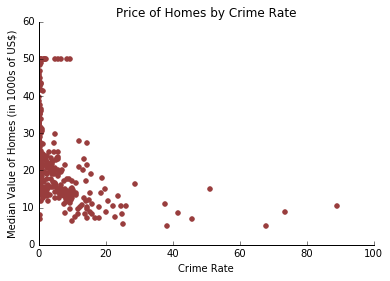

In [130]:
# set variables for plot
y = np.vstack(bdata.target)
x = np.vstack(bdata.data[:,0]) # crime rate

# create scatter plot of price on crime rate
plt.scatter(x, y, color = '#993D3D')

# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off
# set x axis limits
plt.gca().set_xlim([0,100])
# apply labels
plt.gca().set_xlabel('Crime Rate')
plt.gca().set_ylabel('Median Value of Homes (in 1000s of US$)')
plt.gca().set_title('Price of Homes by Crime Rate')

In [131]:
#randomize (using method from PS3 Solution)
np.random.seed(seed=11)

n = len(bdata.data)
rand_order = np.arange(0,n)
np.random.shuffle(rand_order)

# training data - standardized
bdata_train = preprocessing.scale(bdata.data[rand_order[:int(n*.66)],:])
bdata_train_tar = bdata.target[rand_order[:int(n*.66)]]

# est data - standardized
bdata_test = preprocessing.scale(bdata.data[rand_order[int(n*.66):],:])
bdata_test_tar = bdata.target[rand_order[int(n*.66):]]

print "Data partitions created"
print bdata_train.shape, bdata_train_tar.shape
print bdata_test.shape, bdata_test_tar.shape


Data partitions created
(333L, 13L) (333L,)
(173L, 13L) (173L,)


In [132]:
from numpy import sqrt

"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.08
"""
def compute_rmse(predictions, yvalues):
    rmse = np.sqrt(np.mean((predictions-yvalues)**2))
    return round(rmse, 2)

# Create linear regression object
lr = LinearRegression()

# Train the model using the training sets
lr.fit(bdata_train[:,5][np.newaxis].T, bdata_train_tar)

# predict targets in training
bdata_train_hat = lr.predict(bdata_train[:,5][np.newaxis].T)

# calculate RMSE
print 'Training RMSE: ', str(compute_rmse(bdata_train_hat, bdata_train_tar))

# predict targets in test
bdata_test_hat = lr.predict(bdata_test[:,5][np.newaxis].T)

# calculate RMSE
print 'Test RMSE: ', str(compute_rmse(bdata_test_hat, bdata_test_tar))


Training RMSE:  6.44
Test RMSE:  7.03


### 4.2 So many scatterplots!

Choose 8 out of the 14 features of the housing data that you think are most interesting to study.  Create an 8x8 grid of scatterplots showing how each of these variables relate to each other.  You want to produce something that looks generally like [this image](http://iogas.net/wp-content/gallery/iogas-evaluation/scatterplot-matrix-point-density.png).

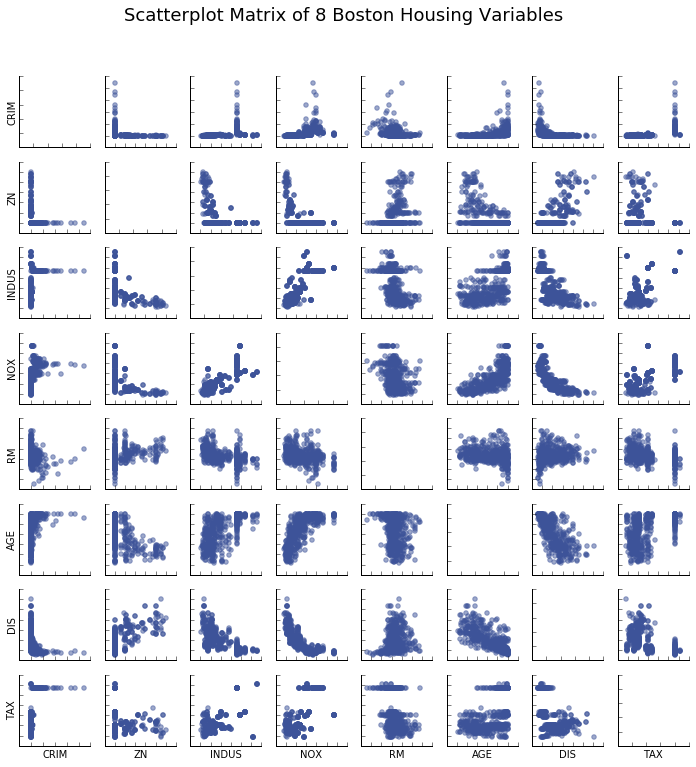

In [133]:
# define features to be included
features_of_interest = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX']

# get the indices of the feature names in the features of interest set
feat = np.in1d(bdata.feature_names, features_of_interest)

# filter for interest features, create new ndarray
bdata.data_8 = bdata.data[:,feat]

# set plot space, give title
plt.figure(figsize=(12,12))
plt.suptitle('Scatterplot Matrix of 8 Boston Housing Variables', fontsize=18)

for i in xrange(8):
    for j in xrange(8):
        plt.subplot(8, 8, i * 8 + j + 1)
        # set variables for plot
        y = np.vstack(bdata.data_8[:,i])
        x = np.vstack(bdata.data_8[:,j]) 

        # create scatter plot of j x i features
        if j != i:
            plt.scatter(x, y, color = '#3D5399', alpha = .5)

        # remove right and top borders
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.tick_params(
            axis='both',     # changes apply to the x-axis
            which='both',    # both major and minor ticks are affected
            bottom='on',    # ticks along the bottom edge are on
            top='off',  # ticks along the top edge are off
            right = 'off',  # ticks along the right edge are off
            labelbottom='on')  # labels along the bottom edge are off
        # set x axis limits
        # plt.gca().set_xlim([2,10])
        # apply labels
        if j == 0:
            plt.ylabel(features_of_interest[i], labelpad=-2)
        if i == 7:
            plt.xlabel(features_of_interest[j], labelpad=0)

        #plt.gca().set_xlabel(bdata.feature_names[i])
        #plt.gca().set_ylabel(bdata.feature_names[j])
        plt.gca().axes.get_xaxis().set_ticklabels([])
        plt.gca().axes.get_yaxis().set_ticklabels([])
        


### 4.3 PCA to the rescue

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn to find the first 12 principal components of your data.  Use only your training set (66% of the data), and use all features *except* the median housing price.  Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 12.

{1: 47.463841211239661, 2: 58.941617717230912, 3: 68.784373786359097, 4: 75.412619734405084, 5: 81.313845572989976, 6: 86.252225206190772, 7: 90.290898743475353, 8: 93.13558842524084, 9: 95.275350091809386, 10: 96.903421413633055, 11: 98.313409328711003, 12: 99.429633616224322}


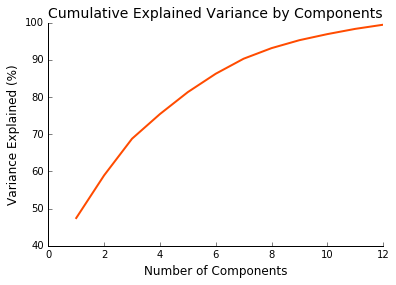

In [134]:
'''pca = PCA(n_components = 12)
pca.fit(bdata_train)
print(pca.explained_variance_ratio_) 
print sum(pca.explained_variance_ratio_)
'''
from sklearn import preprocessing

# create dictionary to hold components and their variance explained
var_expl = {}
for p in range(12):
    # fit pca
    pca = PCA(n_components = p+1)
    pca.fit(bdata_train)
    # calculate variance ratio
    var_ratio = sum(pca.explained_variance_ratio_)*100
    # update dictionary
    var_expl[p+1] = var_ratio
print var_expl

# plot variance explained / components
plt.plot(var_expl.keys(), var_expl.values(), linewidth = 2, color = '#FF4B00')
# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off
# set x axis limits
plt.gca().set_xlim([0,12])
# apply labels
plt.gca().set_xlabel('Number of Components', fontsize = 12)
plt.gca().set_ylabel('Variance Explained (%)', fontsize = 12)
plt.gca().set_title('Cumulative Explained Variance by Components', fontsize = 14)

### 4.4 Visualizing the components

Create a 1X3 grid containing three scatter plots of your training data:

1. PCA 1 vs. PCA 2 (you will need to use `fit_transform` to project your training data onto these two components)
2. PCA 1 (x-axis) vs. median housing value
3. PCA 2 vs. median housing value

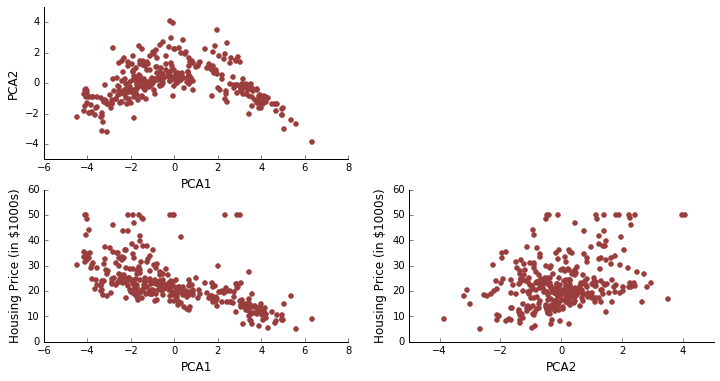

In [135]:
# fit pca model w/ 12 components
pca = PCA(n_components = 12)
pca.fit(bdata_train)

# transform the data for plotting the first 2
pca1 = pca.fit_transform(bdata_train)[:,0]
pca2 = pca.fit_transform(bdata_train)[:,1]

# define figure space
fig = plt.figure(figsize=(12, 6))

# plot pca1 vs pca2
ax1 = fig.add_subplot(221)
ax1.scatter(pca1, pca2, color = '#993D3D')

# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off

# apply labels
plt.gca().set_xlabel('PCA1', fontsize = 12)
plt.gca().set_ylabel('PCA2', fontsize = 12)

# plot pca1 vs housing price
ax2 = fig.add_subplot(223)
ax2.scatter(pca1, bdata_train_tar, color = '#993D3D')
# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off

# apply labels
plt.gca().set_xlabel('PCA1', fontsize = 12)
plt.gca().set_ylabel('Housing Price (in $1000s)', fontsize = 12)


# plot pca2 vs housing price
ax3 = fig.add_subplot(224)
ax3.scatter(pca2, bdata_train_tar, color = '#993D3D')
# remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tick_params(
    axis='both',     # changes apply to the x-axis
    which='both',    # both major and minor ticks are affected
    bottom='on',    # ticks along the bottom edge are on
    top='off',  # ticks along the top edge are off
    right = 'off',  # ticks along the right edge are off
    labelbottom='on')  # labels along the bottom edge are off

# apply labels
plt.gca().set_xlabel('PCA2', fontsize = 12)
plt.gca().set_ylabel('Housing Price (in $1000s)', fontsize = 12)


### 4.5 Regression and PCA

Using just the first Principal Component learned on the training data, project all of your data (including the test data) onto this 1-dimensional subspace using the `fit_transform` function.  Now, using your training data, fit a regression of median housing price on this first principal component of your data.  Report the RMSE of this regression for both the training and test set.  How do these results compare to your results from 4.1?  Interpret your results!

In [136]:
# fit PCA with 1 component
pca1D = PCA(n_components = 1)
pca1D.fit(bdata_train)

# transform using training and test data
pca1D_train = pca1D.fit_transform(bdata_train)
pca1D_test = pca1D.fit_transform(bdata_test)

# create linear regression object
lr = LinearRegression()

# train the model using the training sets
lr.fit(pca1D_train, bdata_train_tar)

# predict using training set
bdata_train_hat = lr.predict(pca1D_train)

# calculate RMSE
print 'Training RMSE: ', str(compute_rmse(bdata_train_hat, bdata_train_tar))

# predict using test set
bdata_test_hat = lr.predict(pca1D_test)

# calculate RMSE
print 'Test RMSE: ', str(compute_rmse(bdata_test_hat, bdata_test_tar))

Training RMSE:  7.37
Test RMSE:  13.01


1-component PCA produces a poorer prediction performance than does using a the 'rm' feature in a simple linear regression (Test RMSE of 13.01 vs 7.03; 'medv' target is in units of $10k). Also notably, the difference between training and test RMSE is greater with 1-component PCA, indicating a larger overfitting issue.